# ***전처리***

In [ ]:
!pip uninstall -y jpype1
!pip install --upgrade --quiet pip setuptools wheel
!pip install --quiet --no-cache-dir --only-binary :all: jpype1==1.5.0 konlpy==0.6.0

# 설치 확인
import sys, jpype
print("Python:", sys.version)
print("JPype1:", jpype.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
JPype1: 1.5.0


In [ ]:
# Java 및 KoNLPy 설치
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq
!pip install --quiet jpype1==1.4.0 konlpy==0.6.0 pandas==2.2.2 tqdm==4.66.4

# JVM 메모리 제한 (세션 다운 방지)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["JAVA_TOOL_OPTIONS"] = "-Xms512m -Xmx2g"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package java-common.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../0-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../1-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../2-libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../3-openjdk-8-jre-headless_8u462-ga~us1-0ubuntu2~22.04.2_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u462-ga~us1-0ubuntu2~22.04.2) ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import gc
import glob
import time
import hashlib
import pandas as pd
import numpy as np
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = "/content/drive/MyDrive/B part/"

file_domestic_violence = os.path.join(base_path, "/content/drive/MyDrive/B part/가정폭력_20210101-20250919.csv")

In [ ]:
df_dv = pd.read_csv(file_domestic_violence, encoding='utf-8-sig', engine='python')
df_dv['사건_유형'] = '가정폭력'

df = df_dv

tqdm.pandas()
okt = Okt()

STOPWORDS = set([
    '기자','앵커','뉴스','보도','밝혔다','위해','관련','말','전','등','이번','지난','동안','이후','따라',
    '명','것','수','고','대해','또','저','위','때','시','뒤','앞','살','세','있다','없다','아니',
    '되다','하다','가다','오다','만','이','그','저희','우리','이날','현재','부터','까지','정도','에서',
    '일','년','분','다시','가장','만큼','이미','경우','다음','사이','때문','일부','조금','특파원',
    '앵커리지','KBS','JTBC','YTN','연합뉴스','단독','강조','설명','주장','확인','조사','수사','발표',
    '취재','송고','리포트','스튜디오','편집','영상','그래픽','코너','온라인','사건','범죄','혐의','경찰',
    '검찰','법원','조사','재판','구속','처벌','처분','기소','선고','징역','징계','당국','대책','강화',
    '마련','필요','피해자','가해자','아이','아동','연인','지역','사회','문제','사람','모두', '개월', '사흘', '지난해'
])

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    return None

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r'<.*?>', ' ', str(text))
    text = re.sub(r'[^가-힣\s]', ' ', text)
    return ' '.join(text.split())

def tokenize_korean_text(text):
    if not text: return []
    try:
        nouns = okt.nouns(text)
        return [w for w in nouns if w not in STOPWORDS and len(w) > 1]
    except:
        return []

KEYS = {
    "가정폭력": [
        "가정폭력", "가정", "보호", "자녀", "배우자", "친족", "접근금지", "폭행", "상담소",
        "쉼터", "가해자", "피해자", "아동학대", "데이트폭력"
    ]
}

def standardize(df):
    col_title = pick_col(df, ['제목','title','기사제목'])
    col_body  = pick_col(df, ['본문','content','text','기사본문','body'])
    col_date  = pick_col(df, ['날짜','일자','게재일','작성일','date','publish_date','게재_일자'])
    col_press = pick_col(df, ['언론사','press','매체','출처','언론사명'])

    out = pd.DataFrame(index=df.index)
    out['제목']   = df[col_title]  if col_title  else ""
    out['본문']   = df[col_body]   if col_body   else ""
    out['날짜']   = df[col_date]   if col_date   else ""
    out['언론사'] = df[col_press]  if col_press  else ""
    return out

meta_df = standardize(df)

df_std = pd.concat([df[['사건_유형']].reset_index(drop=True),
                          meta_df.reset_index(drop=True)], axis=1)
df = df_std

print("원본 로우:", len(df))

def norm_date(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    if re.fullmatch(r'\d{4}-\d{2}-\d{2}', s): return s
    if re.fullmatch(r'\d{8}', s):             return f"{s[:4]}-{s[4:6]}-{s[6:]}"
    if re.fullmatch(r'\d{4}\.\d{2}\.\d{2}', s): return s.replace('.','-')
    if re.fullmatch(r'\d{4}-\d{2}', s):       return f"{s}-01"
    try:
        dt = pd.to_datetime(s, errors="coerce")
        return "" if pd.isna(dt) else str(dt.date())
    except:
        return ""

df['날짜'] = df['날짜'].map(norm_date)
df['연도'] = df['날짜'].map(lambda x: int(x[:4]) if isinstance(x,str) and len(x)>=4 else None)

df['본문_clean'] = df['본문'].fillna("").map(clean_text)
before = len(df)
df = df[df['본문_clean'].str.len() >= 30].copy()
print(f"짧은 기사 제거: {before} → {len(df)}")

df['tokens'] = df['본문_clean'].progress_apply(tokenize_korean_text)
df = df[df['tokens'].str.len() > 0].copy()
df['text_for_analysis'] = df['tokens'].apply(lambda xs: ' '.join(xs))

def has_seed(row):
    seeds = KEYS.get(row['사건_유형'], [])
    hay = (row['제목'] or "") + " " + row['본문'] + " " + row['본문_clean']
    return any(s in hay for s in seeds)

before = len(df)
df = df[df.progress_apply(has_seed, axis=1)].copy()
print(f"주제 외 기사 제거: {before} → {len(df)}")

df['제목_clean'] = df['제목'].fillna("").map(clean_text)
before = len(df)
df.drop_duplicates(subset=['사건_유형','제목_clean','날짜'], keep='first', inplace=True)
print(f"완전 중복 제거: {before} → {len(df)}")

OUT_ANALYSIS = os.path.join(base_path, "final_analysis_data_DV.csv")
OUT_WITH_META = os.path.join(base_path, "final_data_with_meta_DV.csv")
df[['사건_유형','text_for_analysis']].to_csv(OUT_ANALYSIS, index=False, encoding='utf-8-sig')
cols = ['사건_유형','제목','본문','제목_clean','본문_clean','tokens','text_for_analysis','날짜','연도','언론사']
df[cols].to_csv(OUT_WITH_META, index=False, encoding='utf-8-sig')

print(f"분석용 저장: {OUT_ANALYSIS}  (rows={len(df)})\n메타 포함 저장: {OUT_WITH_META} (rows={len(df)})")

원본 로우: 352
짧은 기사 제거: 352 → 348


100%|██████████| 348/348 [00:00<00:00, 42271.00it/s]


주제 외 기사 제거: 348 → 266
완전 중복 제거: 266 → 229
분석용 저장: /content/drive/MyDrive/B part/final_analysis_data_DV.csv  (rows=229)
메타 포함 저장: /content/drive/MyDrive/B part/final_data_with_meta_DV.csv (rows=229)


# **TF-IDF 분석 + 시각화**

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import seaborn as sns

In [ ]:
df = pd.read_csv(OUT_ANALYSIS, encoding="utf-8-sig")
need_cols = {"사건_유형", "text_for_analysis"}
if not need_cols.issubset(df.columns):
    raise ValueError(f"필수 컬럼 누락: {need_cols - set(df.columns)}")

df = df.dropna(subset=["text_for_analysis"])
df = df[df["text_for_analysis"].str.strip().str.len() > 0]
if len(df) == 0:
    raise ValueError("유효한 문서가 없습니다. 전처리 결과를 확인하세요.")

In [ ]:
vectorizer = TfidfVectorizer(
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
    min_df=1,
    max_df=1.0,
    ngram_range=(1,1)
)

tfidf_results = {}

for label, g in df.groupby("사건_유형"):
    corpus = g["text_for_analysis"].tolist()
    if not corpus:
        continue
    X = vectorizer.fit_transform(corpus)
    vocab = np.array(vectorizer.get_feature_names_out())
    scores = np.asarray(X.mean(axis=0)).ravel()
    mask = np.isfinite(scores) & (scores > 0)
    if mask.sum() == 0:
        continue
    order = np.argsort(scores[mask])[::-1]
    words = vocab[mask][order]
    vals  = scores[mask][order]

    top_k = min(100, len(words))
    tfidf_results[label] = dict(zip(words[:top_k], vals[:top_k]))

print("생성된 그룹:", list(tfidf_results.keys()))

생성된 그룹: ['가정폭력']


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.1 MB/s  0:00:00


/tmp/ipython-input-2391634366.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TF-IDF", y="단어", data=df_temp, ax=ax, palette="Blues_r")


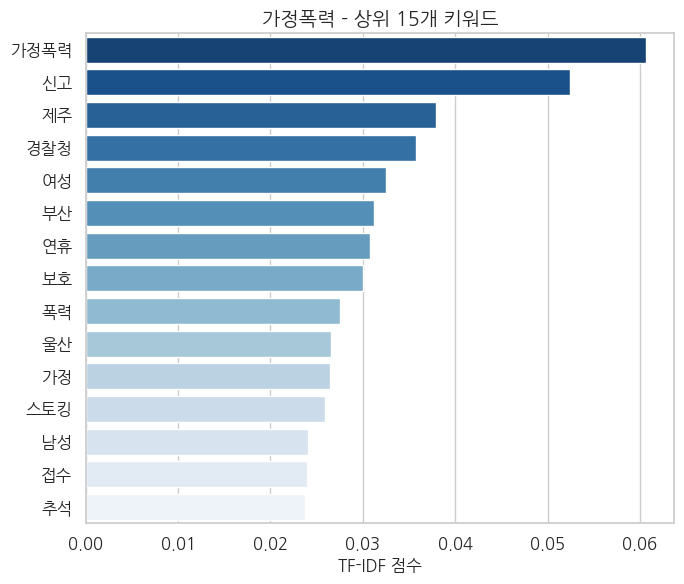

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd

# 바차트
n_groups = len(tfidf_results)
fig, axes = plt.subplots(1, n_groups, figsize=(7*n_groups, 6))
if n_groups == 1: axes = [axes]

for ax, (label, freqs) in zip(axes, tfidf_results.items()):
    df_temp = pd.DataFrame(list(freqs.items()), columns=["단어", "TF-IDF"]).head(15)
    df_temp = df_temp.sort_values("TF-IDF", ascending=False)

    sns.barplot(x="TF-IDF", y="단어", data=df_temp, ax=ax, palette="Blues_r")
    ax.set_title(f"{label} - 상위 15개 키워드", fontproperties=fp, fontsize=14)
    ax.set_xlabel("TF-IDF 점수", fontproperties=fp)
    ax.set_ylabel("", fontproperties=fp)

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontproperties(fp)

plt.tight_layout()
plt.show()

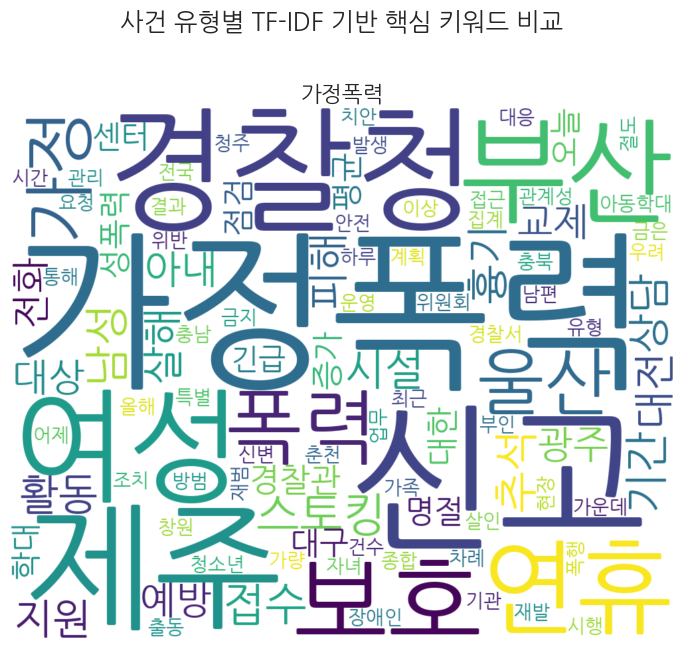

저장 위치: /content/drive/MyDrive/B part/


In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

if not tfidf_results:
    raise SystemExit("유효한 TF-IDF 결과가 없습니다. (라벨/전처리/불용어/TF-IDF 파라미터 점검)")

n = len(tfidf_results)
cols = min(3, n)
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
for ax in axes: ax.axis("off")
plt.suptitle("사건 유형별 TF-IDF 기반 핵심 키워드 비교", fontsize=18)

for i, (label, freqs) in enumerate(tfidf_results.items()):
    wc = WordCloud(
        font_path=FONT_PATH,
        background_color="white",
        width=1000, height=800,
        max_words=100
    ).generate_from_frequencies(freqs)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(label, fontsize=16)
    axes[i].axis("off")

    # 파일 저장
    out_png = os.path.join(base_path, f"wc_{label}.png")
    wc.to_file(out_png)

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

print(f"저장 위치: {base_path}")

# **LDA분석 (프레임)**

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
base_path = "/content/drive/MyDrive/B part/"
file_path  = os.path.join(base_path, "final_analysis_data_DV.csv")

import os
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"'{file_path}' 파일을 찾을 수 없습니다. "
        "이 파일은 '전처리' 섹션의 마지막 셀을 실행하면 생성됩니다. "
        "Google Drive가 올바르게 마운트되었는지 확인하고, "
        "이전 셀들을 다시 실행하여 파일을 생성해 주세요."
    )

df_analysis = pd.read_csv(file_path, encoding="utf-8-sig")

assert {'사건_유형','text_for_analysis'}.issubset(df_analysis.columns), "필수 컬럼 누락"

df_analysis = df_analysis.dropna(subset=['text_for_analysis'])
df_analysis = df_analysis[df_analysis['text_for_analysis'].str.strip().str.len() > 0]
print(f"데이터 수: {len(df_analysis)}")

데이터 수: 229


In [ ]:
# LDA 학습
n_topics = 5
lda_vectorizer = TfidfVectorizer(
    tokenizer=str.split,
    lowercase=False,
    max_features=1000,
    min_df=2,
    max_df=0.95
)
X = lda_vectorizer.fit_transform(df_analysis['text_for_analysis'])

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='online',
    max_iter=20,
    n_jobs=-1
)
lda.fit(X)

print("\nLDA 토픽 모델링 완료: ")
print("문서 수:", X.shape[0], "/ 단어 수:", X.shape[1])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



LDA 토픽 모델링 완료: 
문서 수: 229 / 단어 수: 728


In [ ]:
def print_top_words(model, feature_names, n_top_words=8):
    topic_summary = []
    for topic_idx, topic in enumerate(model.components_):
        top_inds = topic.argsort()[:-n_top_words - 1:-1]
        top_feats = [feature_names[i] for i in top_inds]
        topic_summary.append(f"토픽 {topic_idx+1}: " + ', '.join(top_feats))
    return topic_summary

print("\n토픽별 핵심 키워드")
feature_names = lda_vectorizer.get_feature_names_out()
topic_keywords = print_top_words(lda, feature_names, 8)
for line in topic_keywords:
    print(line)


토픽별 핵심 키워드
토픽 1: 상담, 센터, 전화, 제주, 긴급, 가정폭력, 여성, 성폭력
토픽 2: 부산, 남성, 재범, 경찰관, 가정폭력, 교육, 아파트, 흉기
토픽 3: 가정폭력, 신고, 보호, 연휴, 경찰청, 울산, 스토킹, 추석
토픽 4: 허가, 한계, 학대, 소지, 이혼, 극복, 권한, 징후
토픽 5: 장애인, 광주, 간부, 순찰차, 지적장애, 도시, 여성, 발견


In [ ]:
# 사건유형별 토픽 비중 평균
topic_prob = lda.transform(X)
topic_cols = [f"Topic_{i+1}" for i in range(n_topics)]
topic_df = pd.DataFrame(topic_prob, columns=topic_cols, index=df_analysis.index)
df_merged = pd.concat([df_analysis[['사건_유형']], topic_df], axis=1)

type_topic_avg = df_merged.groupby('사건_유형')[topic_cols].mean()
print("\n사건유형별 평균 토픽 비중")
print(type_topic_avg.sort_index().to_markdown(floatfmt=".3f"))


사건유형별 평균 토픽 비중
| 사건_유형   |   Topic_1 |   Topic_2 |   Topic_3 |   Topic_4 |   Topic_5 |
|:------------|----------:|----------:|----------:|----------:|----------:|
| 가정폭력    |     0.190 |     0.123 |     0.556 |     0.063 |     0.068 |


In [ ]:
def plot_lda_top_words(lda_model, feature_names, n_top_words=10, save_dir="."):
    n_topics = lda_model.n_components
    fig, axes = plt.subplots(n_topics, 1, figsize=(8, 4.2*n_topics), dpi=150)
    if n_topics == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        topic = lda_model.components_[i]
        top_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_feats = [feature_names[j] for j in top_idx]
        weights = topic[top_idx]

        # 가로 막대그래프
        sns.barplot(y=weights, x=top_feats, ax=ax, palette="Blues_r", edgecolor="black")

        ax.set_title(f"토픽 {i+1} 주요 단어", fontsize=15, fontweight="bold", pad=12)
        ax.set_ylabel("가중치", fontsize=12)
        ax.set_xlabel("")
        ax.tick_params(axis="y", labelsize=11)
        ax.tick_params(axis="x", labelsize=11, rotation=0)

        ax.grid(True, axis="y", linestyle="--", alpha=0.4)
        sns.despine(ax=ax)

    plt.suptitle("LDA 토픽별 핵심 단어 시각화(가로형)", fontsize=17, fontweight="bold", y=1.02)
    plt.tight_layout()
    out_path = os.path.join(save_dir, "lda_top_words_clean.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()
    print("저장 완료:", out_path)

/tmp/ipython-input-1069808852.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=weights, x=top_feats, ax=ax, palette="Blues_r", edgecolor="black")
/tmp/ipython-input-1069808852.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=weights, x=top_feats, ax=ax, palette="Blues_r", edgecolor="black")
/tmp/ipython-input-1069808852.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=weights, x=top_feats, ax=ax, palette="Blues_r", edgecolor="black")
/tmp/ipython-input-1069808852.py:15: FutureWarning: 

Passing `palette` without assigning `

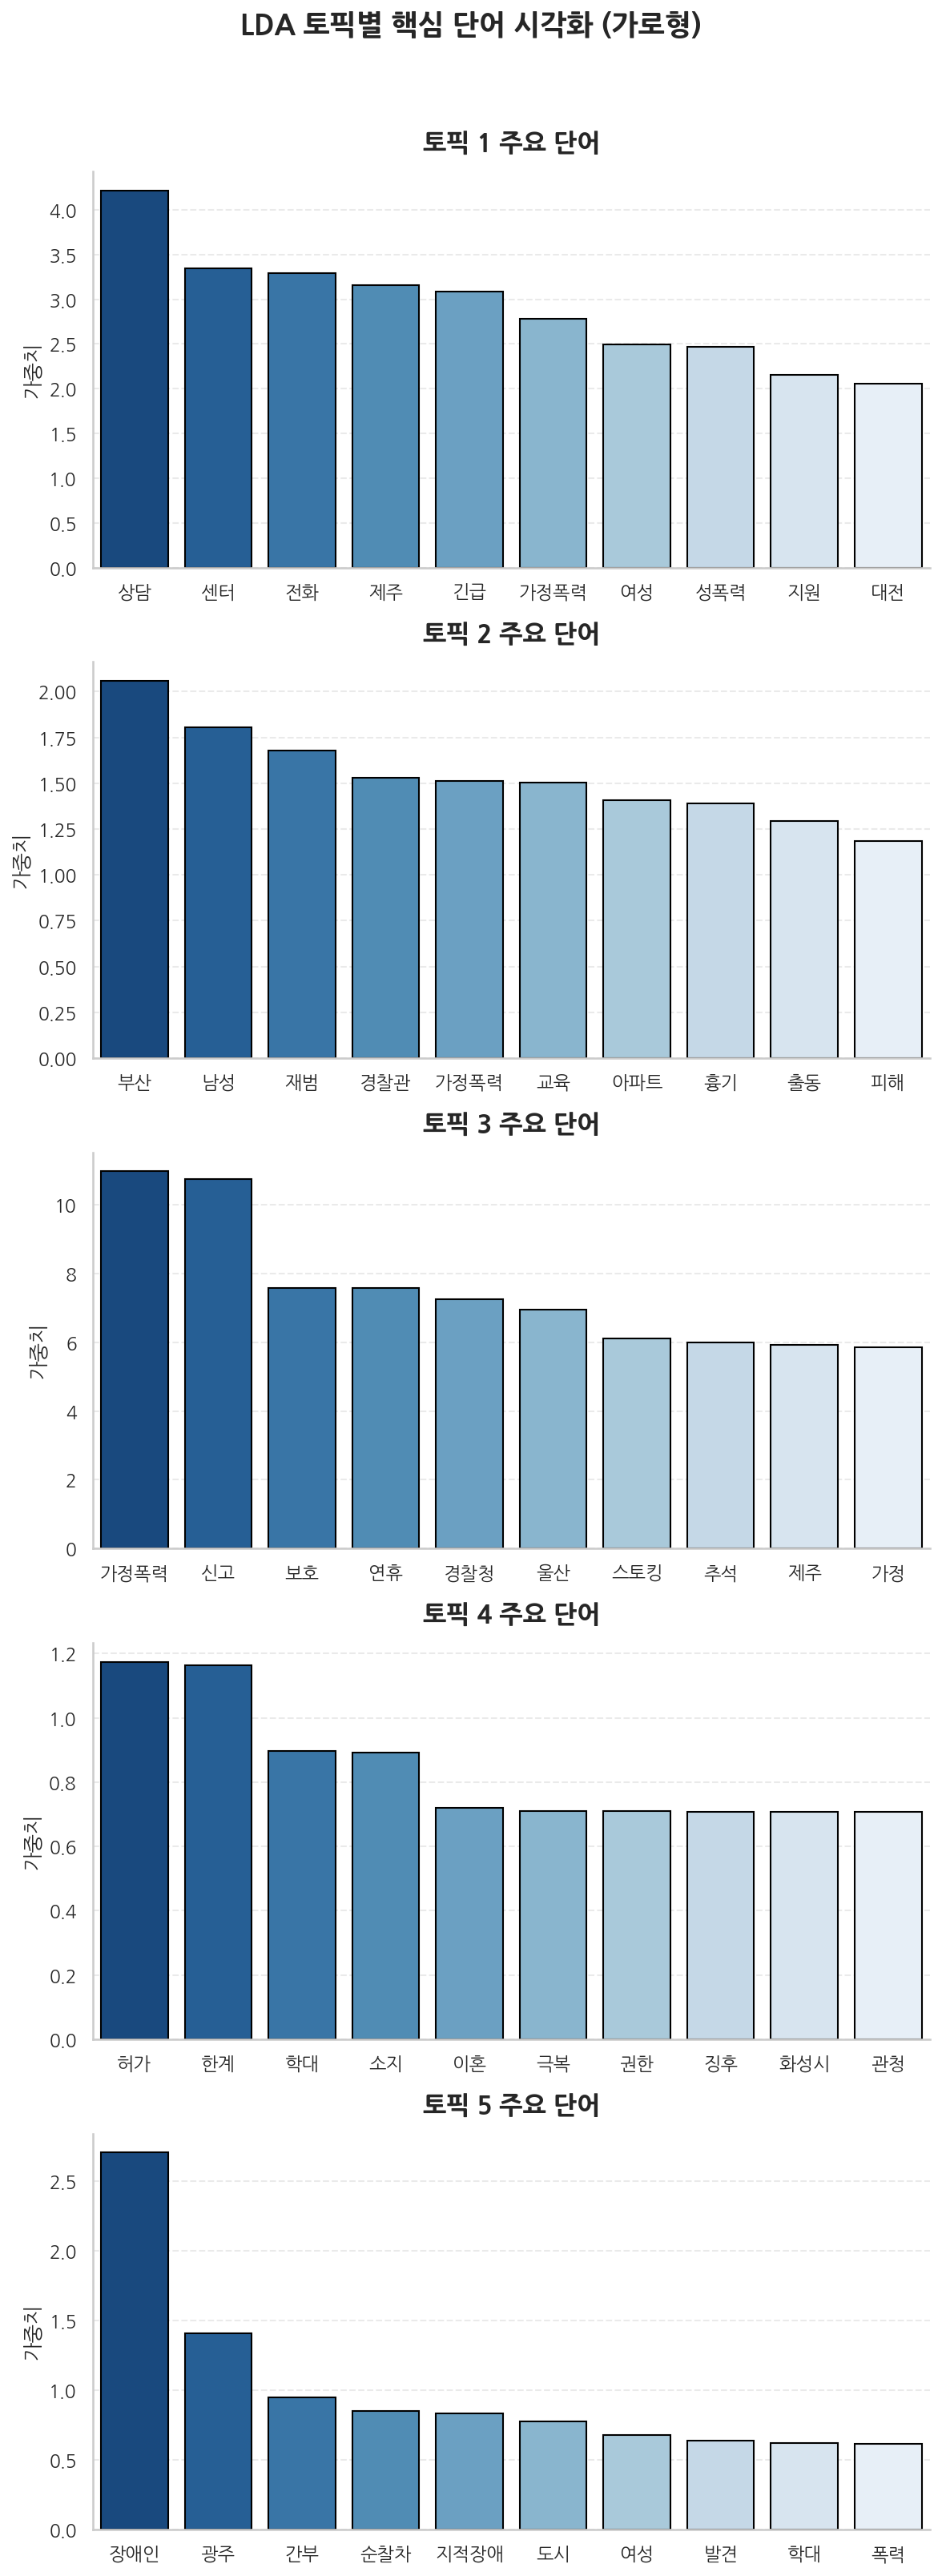

저장 완료: /content/drive/MyDrive/B part/lda_top_words_clean.png


In [ ]:
 plot_lda_top_words(
    lda_model=lda,
    feature_names=lda_vectorizer.get_feature_names_out(),
    n_top_words=10,
    save_dir=base_path # 드라이브 경로
 )

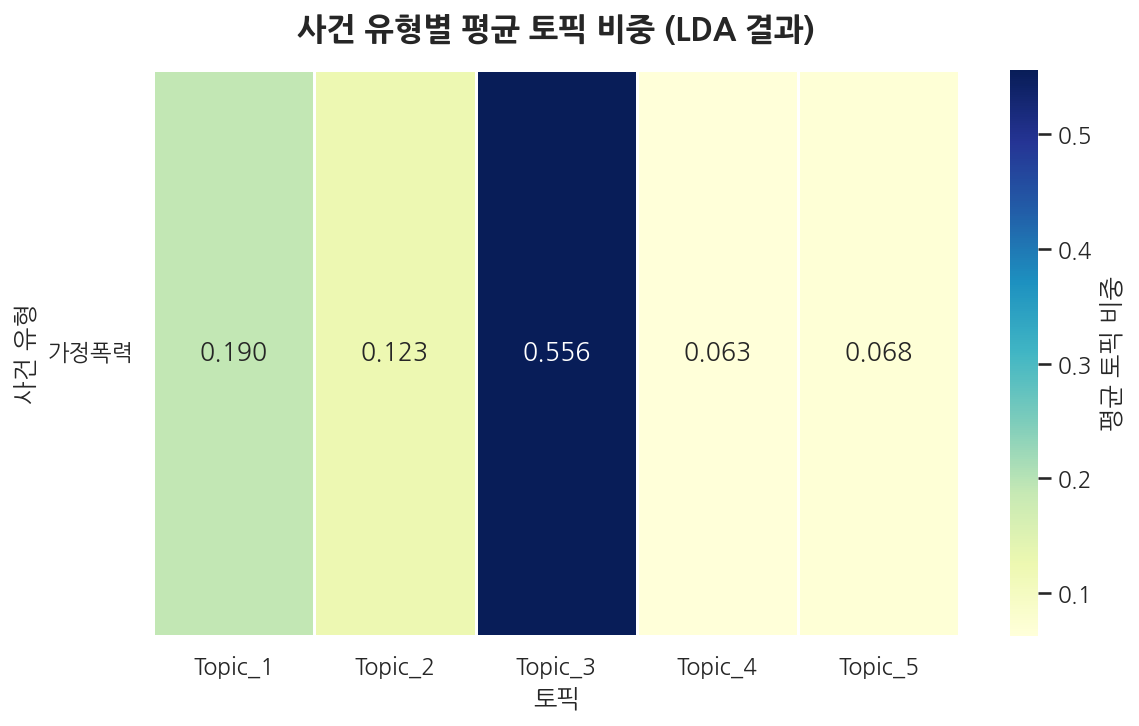

/content/drive/MyDrive/B part/lda_heatmap.png


In [ ]:
plt.figure(figsize=(8,5), dpi=150)

sns.heatmap(
    type_topic_avg,                    # 사건유형별 평균 토픽 비중
    annot=True,                        # 값 표시
    fmt=".3f",                         # 소수점 자리수
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "평균 토픽 비중"}
)

plt.title("사건 유형별 평균 토픽 비중 (LDA 결과)", fontsize=15, weight="bold", pad=15)
plt.xlabel("토픽", fontsize=12)
plt.ylabel("사건 유형", fontsize=12)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
heatmap_path = os.path.join(base_path, "lda_heatmap.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(heatmap_path)

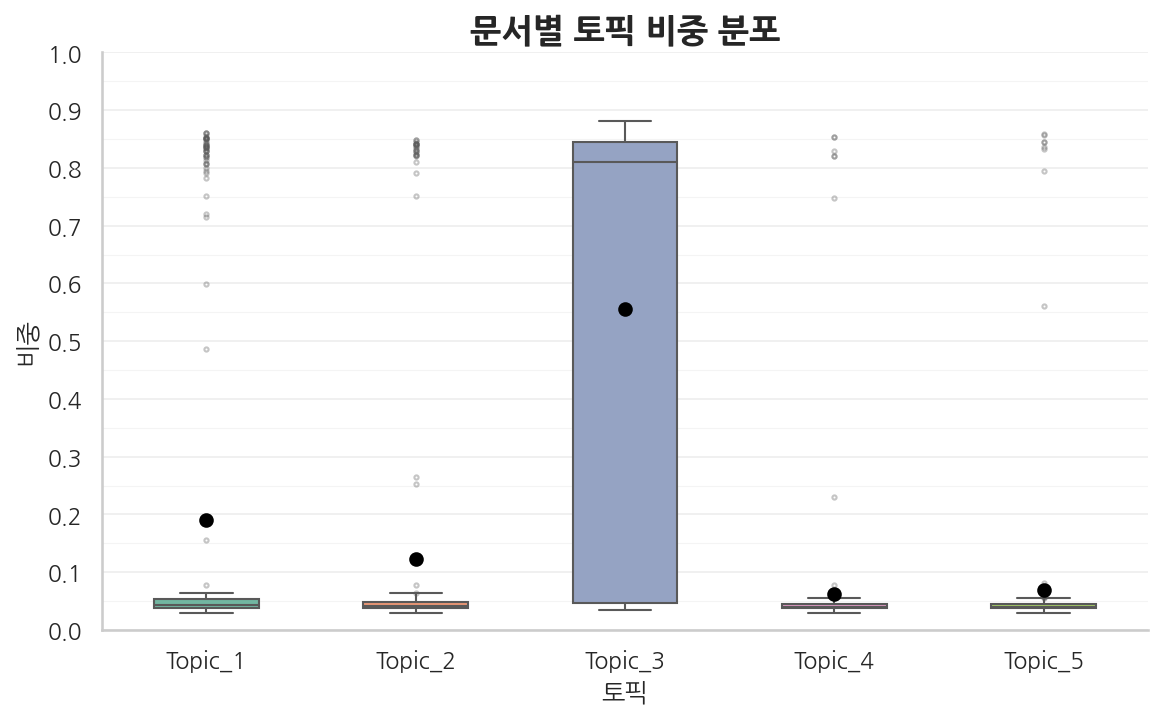

/content/drive/MyDrive/B part/lda_topic_prob_boxplot.png


In [ ]:
# 전체 문서의 토픽 비중 분포
topic_probs = lda.transform(X)
topic_names = [f"Topic_{i+1}" for i in range(lda.n_components)]
topic_df = pd.DataFrame(topic_probs, columns=topic_names)

plt.figure(figsize=(9, 5), dpi=150)
ax = sns.boxplot(
    data=topic_df,
    width=0.5,
    palette=sns.color_palette("Set2", n_colors=len(topic_names)),
    showmeans=True,
    meanprops={"marker": "o", "markersize": 6,
               "markeredgecolor": "black",
               "markerfacecolor": "black"},
    flierprops={"marker": "o", "markersize": 2, "alpha": 0.35}
)

title_kw = {"fontsize": 16, "weight": "bold"}
label_kw = {"fontsize": 12}
ax.set_title("문서별 토픽 비중 분포", **title_kw)
ax.set_xlabel("토픽", **label_kw)
ax.set_ylabel("비중", **label_kw)

ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(True, axis="y", which="major", linewidth=0.8, alpha=0.35)
ax.grid(True, axis="y", which="minor", linewidth=0.5, alpha=0.2)

sns.despine(top=True, right=True)
ax.tick_params(axis="both", labelsize=11)

save_dir = base_path if "base_path" in globals() else "."
out_png = os.path.join(save_dir, "lda_topic_prob_boxplot.png")
plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(out_png)